In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np
from torchvision.transforms import ColorJitter

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
images_path = Path('D:/CatsVsDogsDataset/images')
anno_path = Path('D:/CatsVsDogsDataset/annotations')

In [3]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [4]:
df_train = generate_train_df(anno_path)

class_dict = {'cat': 0, 'dog': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [5]:
print(df_train.shape)
df_train.head()

(3686, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,D:\CatsVsDogsDataset\images\Cats_Test0.png,233,350,0,83,29,197,142
1,D:\CatsVsDogsDataset\images\Cats_Test1.png,500,500,1,128,22,240,222
2,D:\CatsVsDogsDataset\images\Cats_Test10.png,500,375,1,157,56,264,116
3,D:\CatsVsDogsDataset\images\Cats_Test100.png,500,375,0,142,145,206,209
4,D:\CatsVsDogsDataset\images\Cats_Test1000.png,335,500,0,36,14,289,312


In [6]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.5*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.5*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [7]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('D:/CatsVsDogsDataset/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

(350, 233, 3)


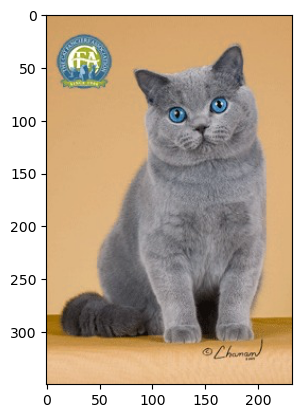

In [8]:
im = cv2.imread(str(df_train.values[0][0]))
bb = create_bb_array(df_train.values[0])
print(im.shape)

Y = create_mask(bb, im)
mask_to_bb(Y)

plt.imshow(im)
#plt.imshow(Y, cmap='gray')

In [57]:
# Data augmentation

# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def mix_colors(x, photo_aug):
    x = (x * 255).astype(np.uint8)
    x = np.array(photo_aug(Image.fromarray(x)), dtype=np.float32)/255
    return x

def transformsXY(path, bb, transforms, photo_aug):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
        x = mix_colors(x, photo_aug)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

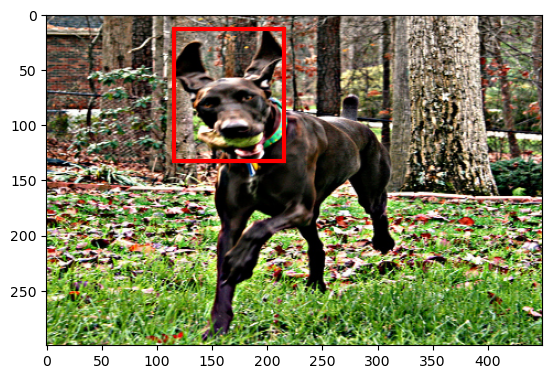

In [60]:
#original
im = cv2.imread(str(df_train.values[1][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[1][9])

(284, 426, 3)


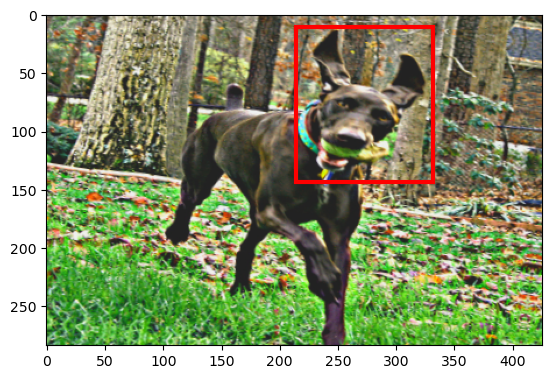

In [67]:
# after transformation
photo_aug = ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.5/3.14)
im, bb = transformsXY(str(df_train.values[1][8]),df_train.values[1][9],True,photo_aug )
print(im.shape)
show_corner_bb(im, bb)
#plt.imshow(create_mask(bb, im))

In [68]:
##

df_train = df_train.reset_index(drop=True)
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [69]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        self.photo_aug = ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.5/3.14)
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms, self.photo_aug)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [78]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

batch_size = 15

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [125]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(weights='ResNet34_Weights.DEFAULT')
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 2))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [72]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [77]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
            print(idx)
        train_loss = sum_loss/total
        #val_loss, val_acc = val_metrics(model, valid_dl, C)
        #print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        print("train_loss %.3f" % (train_loss))
    return sum_loss/total

In [74]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [126]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [79]:
# train
train_epocs(model, optimizer, train_dl, valid_dl, epochs=1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
train_loss 1.002


1.0019656926029572

In [80]:
X_val

,new_path,new_bb
3554,D:\CatsVsDogsDataset\images_resized\Cats_Test8...,"[0.0, 280.0, 107.0, 364.0]"
3081,D:\CatsVsDogsDataset\images_resized\Cats_Test4...,"[23.0, 125.0, 130.0, 320.0]"
2969,D:\CatsVsDogsDataset\images_resized\Cats_Test3...,"[23.0, 246.0, 94.0, 385.0]"
2114,D:\CatsVsDogsDataset\images_resized\Cats_Test2...,"[99.0, 126.0, 173.0, 216.0]"
3347,D:\CatsVsDogsDataset\images_resized\Cats_Test6...,"[0.0, 54.0, 172.0, 283.0]"
...,...,...
3587,D:\CatsVsDogsDataset\images_resized\Cats_Test9...,"[22.0, 89.0, 188.0, 324.0]"
1506,D:\CatsVsDogsDataset\images_resized\Cats_Test2...,"[82.0, 82.0, 185.0, 360.0]"
1452,D:\CatsVsDogsDataset\images_resized\Cats_Test2...,"[28.0, 124.0, 219.0, 358.0]"
96,D:\CatsVsDogsDataset\images_resized\Cats_Test1...,"[0.0, 88.0, 180.0, 269.0]"


In [119]:
# resizing test image
path = 'D:/CatsVsDogsDataset/images_resized/Cats_Test2351.png'
im = read_image(path)
im = cv2.resize(im, (int(1.5*300), 300))
#cv2.imwrite('D:/CatsVsDogsDataset/images_test/Cats_Test1916.png', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':path}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 426])

In [127]:
model.eval()

with torch.no_grad():
    out_class, out_bb = model(xx.cuda())
    
out_class, out_bb


(tensor([[-0.2893, -0.0131]], device='cuda:0'),
 tensor([[ 0.6048,  0.0718,  0.0772, -0.1723]], device='cuda:0'))

In [128]:
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([-0.0131], device='cuda:0'),
indices=tensor([1], device='cuda:0'))

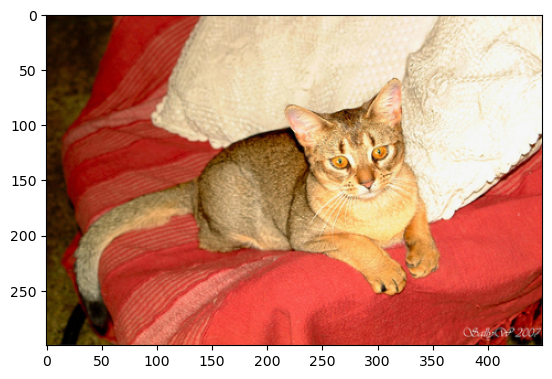

In [129]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

In [85]:
X_train.shape

(2948, 2)

In [86]:
import gc
torch.cuda.empty_cache()
gc.collect()

24775